Mounted at /content/drive
Found 3600 images belonging to 5 classes.
Found 76 images belonging to 5 classes.
Found 81 images belonging to 5 classes.
Class Weights: {0: 1.0285714285714285, 1: 1.0, 2: 1.0140845070422535, 3: 1.0285714285714285, 4: 0.935064935064935}
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 1849s 3s/step - accuracy: 0.4107 - loss: 1.5759 - precision: 0.4782 - recall: 0.2943 - val_accuracy: 0.3421 - val_loss: 2.3070 - val_precision: 0.3529 - val_recall: 0.3158 - learning_rate: 1.0000e-04
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 105s 234ms/step - accuracy: 0.8513 - loss: 0.4157 - precision: 0.8774 - recall: 0.8292 - val_accuracy: 0.7632 - val_loss: 1.3210 - val_precision: 0.7703 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 106s 236ms/step - accuracy: 0.9266 - loss: 0.2336 - precision: 0.9332 - recall: 0.9200 - val_accuracy: 0.7500 - val_loss: 1.2935 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 140s 231ms/step - accuracy: 0.9413 - loss: 0.1789 - precision: 0.9481 - recall: 0.9359 - val_accuracy: 0.7368 - val_loss: 1.8425 - val_precision: 0.7368 - val_recall: 0.7368 - learning_rate: 1.0000e-04
Epoch 5/30
450/450 ━━━━━━━━━━━━━━━

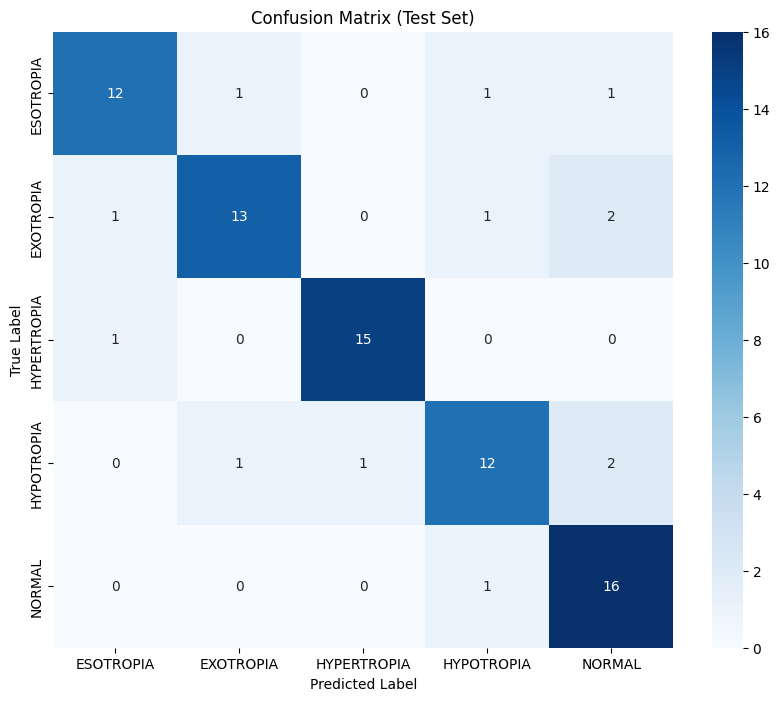

✅ Test Accuracy: 83.95%
✅ Test Precision: 0.8500
✅ Test Recall: 0.8395
✅ Test F1 Score: 0.8447

✅ Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.87      0.76      0.81        17
           2       0.94      0.94      0.94        16
           3       0.80      0.75      0.77        16
           4       0.76      0.94      0.84        17

    accuracy                           0.84        81
   macro avg       0.84      0.84      0.84        81
weighted avg       0.84      0.84      0.84        81



In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers, models, optimizers, metrics, backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# ✅ **Mount Google Drive**
drive.mount('/content/drive')

# ✅ **Set Dataset Path**
dataset_path = "/content/drive/MyDrive/Strabismus_New"
train_path = os.path.join(dataset_path, "Final_Train_data")
val_path = os.path.join(dataset_path, "val")
test_path = os.path.join(dataset_path, "test")

# ✅ **Check if Dataset Exists**
for path in [train_path, val_path, test_path]:
    if not os.path.exists(path):
        raise ValueError(f"Dataset path '{path}' does not exist. Check your Drive location.")

# ✅ **Set Constants**
IMG_SIZE = 300
BATCH_SIZE = 8
EPOCHS = 30

# ✅ **Define ImageDataGenerator (Rescaling)**
datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen.flow_from_directory(
    train_path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)

val_generator = datagen.flow_from_directory(
    val_path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)

test_generator = datagen.flow_from_directory(
    test_path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# ✅ **Extract Class Weights**
y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# ✅ **Enable Mixed Precision**
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ✅ **Load EfficientNetB7 (Frozen)**
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[-30:]:
    layer.trainable = True

# ✅ **Build Model**
x = base_model.output
x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.LayerNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)

# ✅ **Custom AdamW Optimizer**
class AdamW(optimizers.Adam):
    def __init__(self, learning_rate=1e-4, weight_decay=1e-5, **kwargs):
        super().__init__(learning_rate=learning_rate, **kwargs)
        self.weight_decay = weight_decay

    def _resource_apply_dense(self, grad, var, apply_state=None):
        if grad is not None and 'kernel' in var.name:
            grad = grad + self.weight_decay * var
        return super()._resource_apply_dense(grad, var, apply_state)

optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)

# ✅ **Callbacks**
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ✅ **Compile Model**
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')]
)

# ✅ **Train Model**
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# ✅ **Evaluate on Test Set**
metrics = model.evaluate(test_generator)
test_loss, test_accuracy, test_precision, test_recall = metrics

# ✅ **Compute Confusion Matrix on Test Set**
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix_test = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# ✅ **Print Final Results**
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"✅ Test Precision: {test_precision:.4f}")
print(f"✅ Test Recall: {test_recall:.4f}")
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)
print(f"✅ Test F1 Score: {test_f1:.4f}")
print("\n✅ Classification Report:")
print(classification_report(y_true, y_pred_classes))